## 1. Install Required Libraries


In [1]:
# Install UMAP and HDBSCAN if not already installed
# !pip install umap-learn hdbscan

## 2. Load Data and Preprocess


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)
sns.set_style(style="whitegrid")

# Load data
df = pd.read_csv("Analytica.csv")

OCEAN = {
    "EXT": "Extraversion",
    "EST": "Neuroticism",
    "AGR": "Agreeableness",
    "CSN": "Conscientiousness",
    "OPN": "Openness",
}
dimensions = list(OCEAN.keys())

print(f"Dataset shape: {df.shape}")
print(
    f"Target available: {df['target'].notna().sum()} / {len(df)} ({df['target'].notna().mean()*100:.1f}%)"
)
df.head()

Dataset shape: (34163, 112)
Target available: 5096 / 34163 (14.9%)


,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,EXT_time,EST,EST_time,AGR,AGR_time,CSN,CSN_time,OPN,OPN_time,target
0,3.0,2.0,2.0,4.0,4.0,4.0,5.0,3.0,1.0,3.0,...,72.625,0.44,46.155,0.24,82.665,0.10,62.022,0.10,40.415,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,2.0,4.0,3.0,5.0,...,45.790,0.42,36.420,-0.14,86.422,0.10,56.401,0.26,38.205,0.0
2,3.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,2.0,2.0,...,64.250,0.42,50.268,0.50,58.487,0.18,44.737,0.34,51.454,NaN
3,1.0,5.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,5.0,...,50.384,0.64,59.489,0.22,59.080,0.18,66.815,0.32,58.911,NaN
4,1.0,4.0,3.0,5.0,1.0,2.0,2.0,4.0,2.0,4.0,...,59.927,0.46,39.848,0.40,97.554,0.24,45.858,0.42,48.390,0.0


In [3]:
# Prepare features and target
X = df.drop(columns=["target"])
y = df["target"]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features shape: {X_scaled.shape}")

Features shape: (34163, 111)


## 3. UMAP Parameter Sweep

Let's find the optimal number of UMAP components by evaluating silhouette scores.


In [6]:
import umap
import hdbscan

# Parameter sweep for UMAP n_components
n_components_range = [5, 10, 30, 50, 75, 100]
results = []

for n_comp in n_components_range:
    print(f"Testing n_components={n_comp}...", end=" ")

    # UMAP dimensionality reduction
    reducer = umap.UMAP(
        n_components=n_comp,
        n_neighbors=30,
        min_dist=0.0,
        metric="euclidean",
        random_state=42,
    )
    X_umap = reducer.fit_transform(X_scaled)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=200, min_samples=15, cluster_selection_method="eom"
    )
    labels = clusterer.fit_predict(X_umap)

    # Calculate metrics (exclude noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Silhouette score (only if we have valid clusters)
    if n_clusters > 1:
        # Filter out noise for silhouette calculation
        mask = labels != -1
        sil_score = silhouette_score(X_umap[mask], labels[mask])
    else:
        sil_score = -1

    results.append(
        {
            "n_components": n_comp,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "noise_pct": n_noise / len(labels) * 100,
            "silhouette": sil_score,
        }
    )

    print(
        f"Clusters: {n_clusters}, Noise: {n_noise} ({n_noise/len(labels)*100:.1f}%), Silhouette: {sil_score:.4f}"
    )

results_df = pd.DataFrame(results)
results_df

Testing n_components=5... Clusters: 8, Noise: 15740 (46.1%), Silhouette: -0.0032
Testing n_components=10... Clusters: 8, Noise: 15740 (46.1%), Silhouette: -0.0032
Testing n_components=10... Clusters: 4, Noise: 6112 (17.9%), Silhouette: 0.0562
Testing n_components=30... Clusters: 4, Noise: 6112 (17.9%), Silhouette: 0.0562
Testing n_components=30... Clusters: 4, Noise: 5818 (17.0%), Silhouette: 0.0235
Testing n_components=50... Clusters: 4, Noise: 5818 (17.0%), Silhouette: 0.0235
Testing n_components=50... Clusters: 4, Noise: 5711 (16.7%), Silhouette: 0.0179
Testing n_components=75... Clusters: 4, Noise: 5711 (16.7%), Silhouette: 0.0179
Testing n_components=75... Clusters: 4, Noise: 4592 (13.4%), Silhouette: 0.0081
Testing n_components=100... Clusters: 4, Noise: 4592 (13.4%), Silhouette: 0.0081
Testing n_components=100... Clusters: 5, Noise: 16826 (49.3%), Silhouette: -0.0067
Clusters: 5, Noise: 16826 (49.3%), Silhouette: -0.0067


,n_components,n_clusters,n_noise,noise_pct,silhouette
0,5,8,15740,46.073237,-0.003247
1,10,4,6112,17.890700,0.056167
2,30,4,5818,17.030120,0.023481
3,50,4,5711,16.716916,0.017918
4,75,4,4592,13.441442,0.008105
5,100,5,16826,49.252115,-0.006696


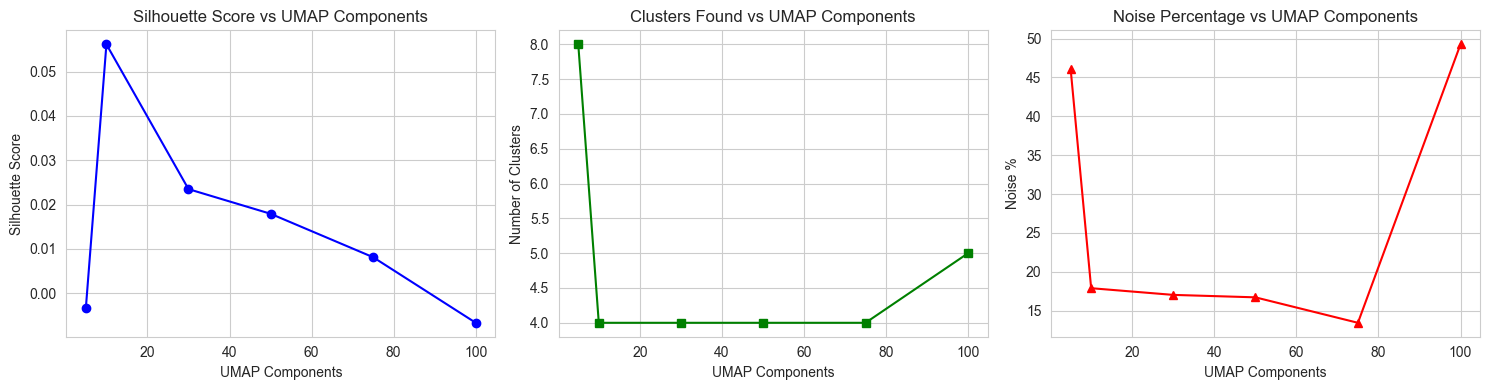

In [7]:
# Visualize the parameter sweep
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette Score
axes[0].plot(
    results_df["n_components"], results_df["silhouette"], marker="o", color="blue"
)
axes[0].set_xlabel("UMAP Components")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score vs UMAP Components")

# Number of Clusters
axes[1].plot(
    results_df["n_components"], results_df["n_clusters"], marker="s", color="green"
)
axes[1].set_xlabel("UMAP Components")
axes[1].set_ylabel("Number of Clusters")
axes[1].set_title("Clusters Found vs UMAP Components")

# Noise Percentage
axes[2].plot(
    results_df["n_components"], results_df["noise_pct"], marker="^", color="red"
)
axes[2].set_xlabel("UMAP Components")
axes[2].set_ylabel("Noise %")
axes[2].set_title("Noise Percentage vs UMAP Components")

plt.tight_layout()
plt.show()

## 4. Final Model with Optimal Parameters


In [8]:
# Select best n_components based on silhouette score
best_idx = results_df["silhouette"].idxmax()
best_n_components = results_df.loc[best_idx, "n_components"]
print(
    f"Best n_components: {best_n_components} (Silhouette: {results_df.loc[best_idx, 'silhouette']:.4f})"
)

# Fit final UMAP model
reducer = umap.UMAP(
    n_components=best_n_components,
    n_neighbors=30,
    min_dist=0.0,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X_scaled)

# Fit final HDBSCAN model
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=15,
    cluster_selection_method="eom",
    prediction_data=True,
)
cluster_labels = clusterer.fit_predict(X_umap)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\nFinal Results:")
print(f"  Number of clusters: {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")

# Cluster distribution
print(f"\nCluster distribution:")
for i in sorted(set(cluster_labels)):
    count = list(cluster_labels).count(i)
    label = "Noise" if i == -1 else f"Cluster {i}"
    print(f"  {label}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")

Best n_components: 10 (Silhouette: 0.0562)

Final Results:
  Number of clusters: 4
  Noise points: 6112 (17.9%)

Cluster distribution:
  Noise: 6112 samples (17.9%)
  Cluster 0: 385 samples (1.1%)
  Cluster 1: 382 samples (1.1%)
  Cluster 2: 412 samples (1.2%)
  Cluster 3: 26872 samples (78.7%)

Final Results:
  Number of clusters: 4
  Noise points: 6112 (17.9%)

Cluster distribution:
  Noise: 6112 samples (17.9%)
  Cluster 0: 385 samples (1.1%)
  Cluster 1: 382 samples (1.1%)
  Cluster 2: 412 samples (1.2%)
  Cluster 3: 26872 samples (78.7%)


## 5. Visualization (2D Projection)


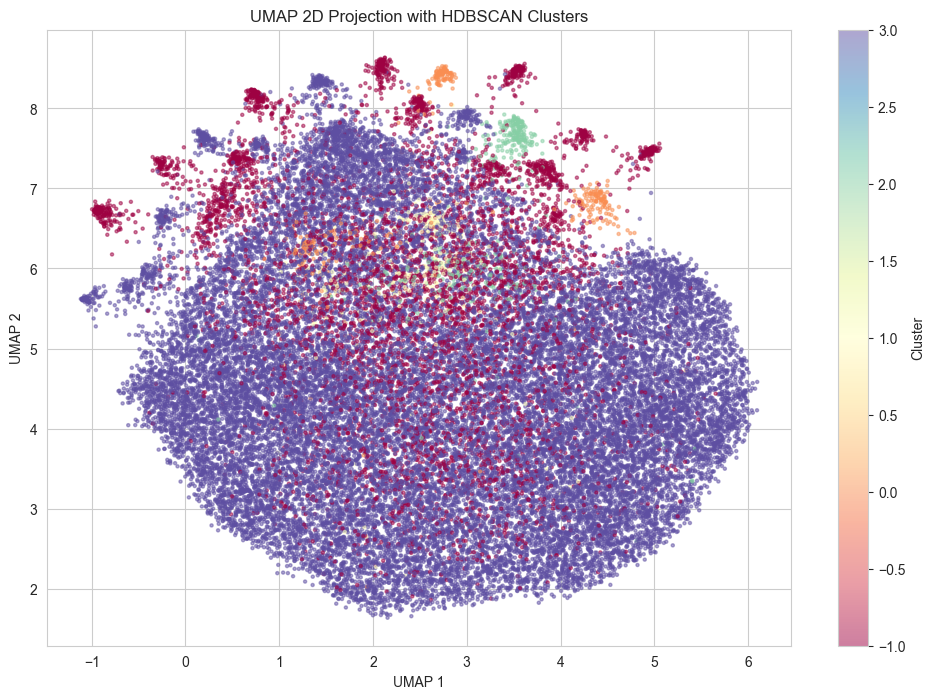

In [9]:
# Create 2D UMAP for visualization
reducer_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap_2d = reducer_2d.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_umap_2d[:, 0], X_umap_2d[:, 1], c=cluster_labels, cmap="Spectral", alpha=0.5, s=5
)
plt.colorbar(scatter, label="Cluster")
plt.title("UMAP 2D Projection with HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

## 6. Analysis: Cluster vs Target


In [10]:
# Create analysis dataframe
analysis_df = df[list(OCEAN.keys()) + ["target"]].copy()
analysis_df["cluster"] = cluster_labels

# Group by cluster and analyze target distribution
cluster_analysis = analysis_df.groupby("cluster").agg(
    {"target": ["count", "sum", "mean"], **{dim: "mean" for dim in dimensions}}
)
cluster_analysis.columns = [
    "_".join(col).strip() for col in cluster_analysis.columns.values
]
cluster_analysis = cluster_analysis.rename(
    columns={
        "target_count": "total_count",
        "target_sum": "target_sum",
        "target_mean": "target_rate",
    }
)

print("Cluster Analysis:")
cluster_analysis

Cluster Analysis:


,total_count,target_sum,target_rate,EXT_mean,EST_mean,AGR_mean,CSN_mean,OPN_mean
cluster,,,,,,,,
-1,929,450.0,0.484392,-0.012454,0.346708,0.281044,0.206247,0.402408
0,53,24.0,0.452830,-0.020208,0.344312,0.292052,0.211896,0.387117
1,57,29.0,0.508772,-0.013194,0.344450,0.285236,0.234241,0.396230
2,56,26.0,0.464286,-0.018738,0.362816,0.287816,0.228689,0.356893
3,4001,1884.0,0.470882,-0.016761,0.337389,0.288332,0.214582,0.399853


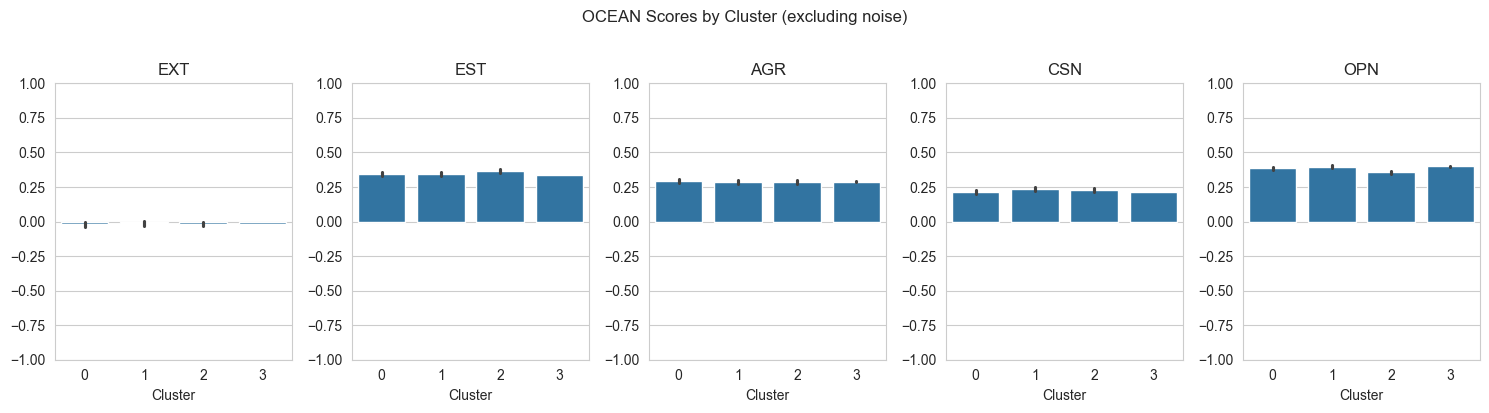

In [11]:
# Visualize OCEAN scores by cluster
plt.figure(figsize=(15, 4))

for index, dimension in enumerate(dimensions):
    plt.subplot(1, 5, index + 1)
    # Filter out noise for cleaner visualization
    plot_df = analysis_df[analysis_df["cluster"] != -1]
    sns.barplot(data=plot_df, x="cluster", y=dimension, estimator="mean")
    plt.xlabel("Cluster")
    plt.ylabel("")
    plt.ylim(-1, 1)
    plt.title(dimension)

plt.suptitle("OCEAN Scores by Cluster (excluding noise)", y=1.02)
plt.tight_layout()
plt.show()

## 7. Generate Predictions


In [12]:
# Prepare prediction dataframe
study = df[["ID", "target"]].copy()
study["cluster"] = cluster_labels

# Calculate average target per cluster (excluding noise)
cluster_means = (
    study[study["cluster"] != -1].groupby("cluster")["target"].mean().reset_index()
)
cluster_means.columns = ["cluster", "avg_target"]

# For noise points, use overall mean
overall_mean = study["target"].mean()

# Merge and create predictions
study = study.merge(cluster_means, on="cluster", how="left")

# Handle noise points (cluster == -1)
study.loc[study["cluster"] == -1, "avg_target"] = overall_mean

# Filter to unknown targets only
study = study[study["target"].isna()]

# Make predictions
study["prediction"] = (study["avg_target"] > 0.5).astype(int)

# Create submission
answer = study[["ID", "prediction"]]
print(f"Predictions generated: {len(answer)}")
print(f"\nPrediction distribution:")
print(answer["prediction"].value_counts())
answer.head(10)

Predictions generated: 29067

Prediction distribution:
prediction
0    28742
1      325
Name: count, dtype: int64


,ID,prediction
0,20160303022202,0
2,20160303052049,0
3,20160303052319,0
5,20160303055318,0
6,20160303063505,0
7,20160303064930,0
8,20160303070035,0
9,20160303080108,0
10,20160303080415,0
11,20160303084611,0


In [13]:
# Save submission
answer.to_csv("submit_umap_hdbscan.csv", index=False)
print("Saved to submit_umap_hdbscan.csv")

Saved to submit_umap_hdbscan.csv


## 8. Comparison with PCA + K-Means


In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA + K-Means baseline
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compare silhouette scores
sil_kmeans = silhouette_score(X_pca, kmeans_labels)

# UMAP + HDBSCAN (excluding noise)
mask = cluster_labels != -1
sil_hdbscan = silhouette_score(X_umap[mask], cluster_labels[mask])

print("=" * 50)
print("COMPARISON: PCA+K-Means vs UMAP+HDBSCAN")
print("=" * 50)
print(f"\nPCA + K-Means:")
print(f"  Silhouette Score: {sil_kmeans:.4f}")
print(f"  Number of clusters: 5 (fixed)")
print(f"\nUMAP + HDBSCAN:")
print(f"  Silhouette Score: {sil_hdbscan:.4f}")
print(f"  Number of clusters: {n_clusters} (automatic)")
print(f"  Noise points handled: {n_noise}")
print(f"\nImprovement: {((sil_hdbscan - sil_kmeans) / sil_kmeans * 100):.1f}%")

COMPARISON: PCA+K-Means vs UMAP+HDBSCAN

PCA + K-Means:
  Silhouette Score: 0.1388
  Number of clusters: 5 (fixed)

UMAP + HDBSCAN:
  Silhouette Score: 0.0562
  Number of clusters: 4 (automatic)
  Noise points handled: 6112

Improvement: -59.5%
